In [1]:
# Required Libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import random
import warnings

from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

warnings.filterwarnings("ignore")

In [2]:
# Extracting Locations and Exporting
DATA_ROOT = Path("../data")
TRAIN_DIR = DATA_ROOT / "asl_alphabet_train"
TEST_DIR  = DATA_ROOT / "asl_alphabet_test"
OUTPUT_DIR = Path("../saved_models")

MODEL_PATH = OUTPUT_DIR / "asl_mobilenetv2.h5"
CLASS_MAP_JSON = OUTPUT_DIR / "class_names.json"

Total Classes: 29
Sample classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


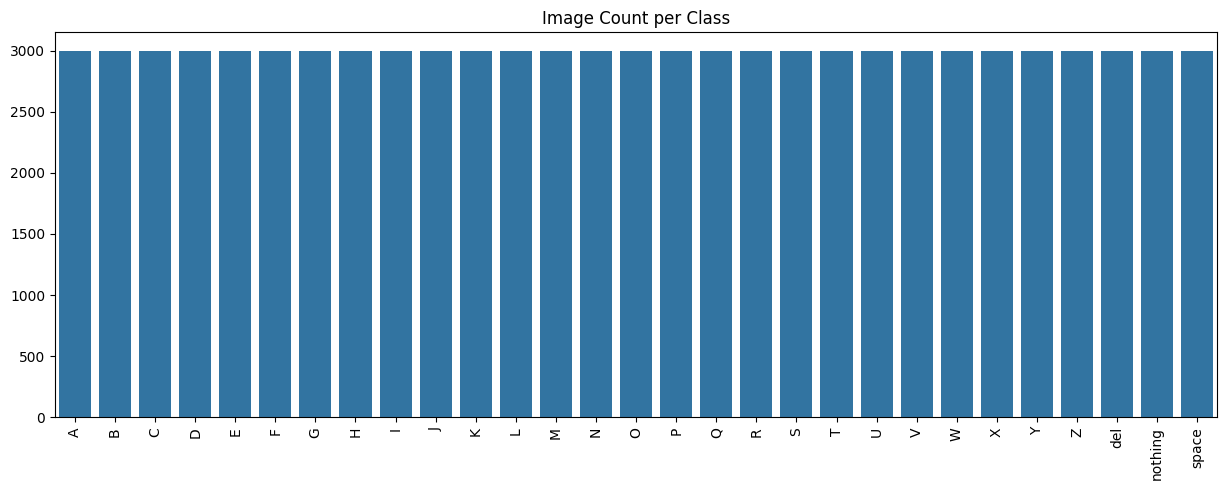

In [3]:
# Dataset Summary
classes = sorted(os.listdir(TRAIN_DIR))
print(f"Total Classes: {len(classes)}")
print("Sample classes:", classes[:10])

class_counts = {cls: len(os.listdir(TRAIN_DIR/cls)) for cls in classes}
plt.figure(figsize=(15,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Image Count per Class")
plt.show()

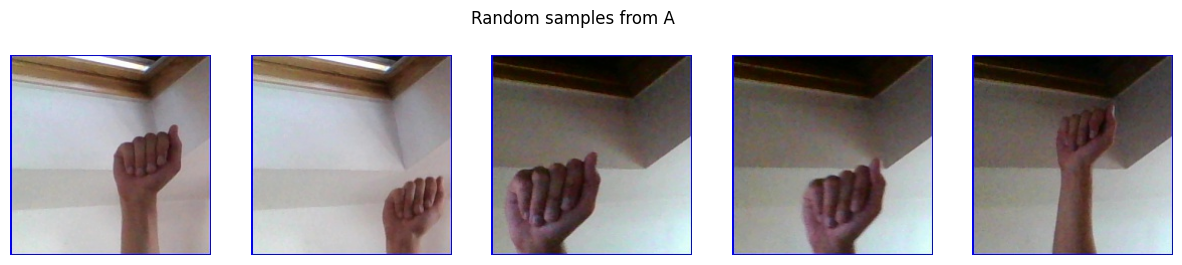

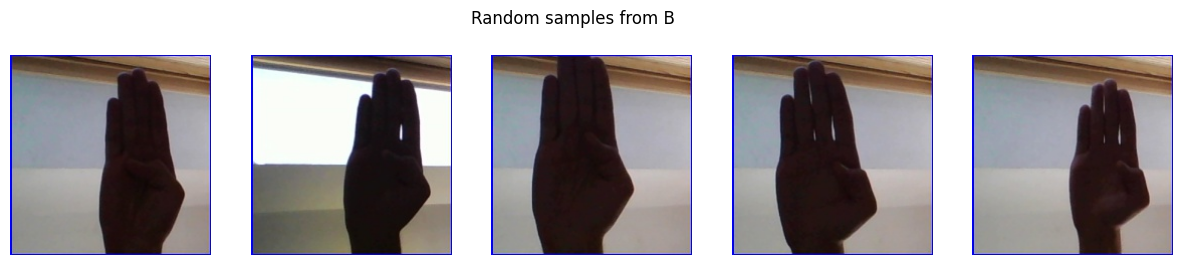

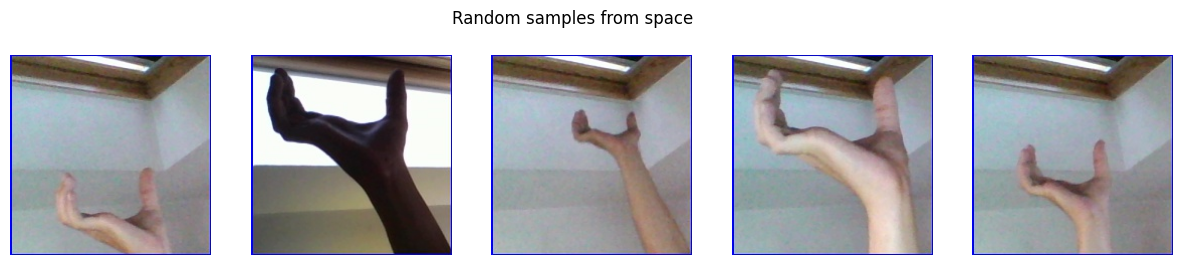

In [4]:
# Sample Running of the dataset
import cv2

def show_random_samples(class_name, n=5):
    plt.figure(figsize=(15,3))
    img_files = os.listdir(TRAIN_DIR/class_name)
    for i in range(n):
        img = plt.imread(TRAIN_DIR/class_name/random.choice(img_files))
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Random samples from {class_name}")

show_random_samples("A")
show_random_samples("B")
show_random_samples("space")

In [5]:
# Data Generators 
IMG_SIZE = (160,160) 
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation"
)

Found 78300 images belonging to 29 classes.
Found 8696 images belonging to 29 classes.


In [6]:
# Loading Model
if MODEL_PATH.exists():
    model = load_model(MODEL_PATH)
    print("✅ Model loaded.")
else:
    print("⚠️ No trained model found. Will need to train.")

✅ Model loaded.


In [7]:
# Evaluate baseline on validation
if 'model' in globals():
    val_loss, val_acc = model.evaluate(val_gen, verbose=1)
    print(f"Validation Accuracy: {val_acc:.2%}, Loss: {val_loss:.4f}")

272/272 ━━━━━━━━━━━━━━━━━━━━ 66s 235ms/step - accuracy: 0.9602 - loss: 0.1968
Validation Accuracy: 96.02%, Loss: 0.1968


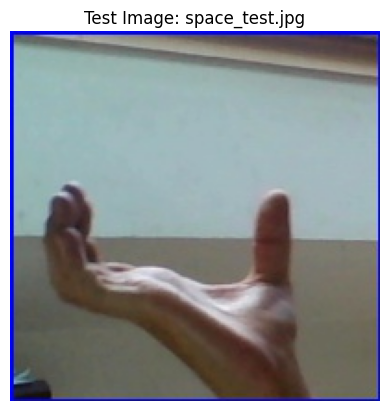

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
Predicted: space


In [8]:
# Predictions on test set
if TEST_DIR.exists() and 'model' in globals():
    test_files = os.listdir(TEST_DIR)
    sample_file = random.choice(test_files)
    img = plt.imread(TEST_DIR/sample_file)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Test Image: {sample_file}")
    plt.show()

    # preprocess & predict
    img_resized = tf.image.resize(img, IMG_SIZE) / 255.0
    pred = model.predict(np.expand_dims(img_resized, axis=0))
    predicted_class = classes[np.argmax(pred)]
    print(f"Predicted: {predicted_class}")

In [9]:
# Evaulution
EVAL_PERCENT = 0.12
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# DataFrame with 12% per class
train_files = []
train_labels = []

for cls in sorted(os.listdir(TRAIN_DIR)):
    cls_folder = TRAIN_DIR / cls
    if cls_folder.is_dir():
        imgs = list(cls_folder.glob("*.jpg"))
        n_sample = max(1, int(len(imgs) * EVAL_PERCENT))
        sampled_imgs = random.sample(imgs, n_sample)
        train_files.extend([str(img.relative_to(TRAIN_DIR)) for img in sampled_imgs])
        train_labels.extend([cls]*len(sampled_imgs))

train_df = pd.DataFrame({
    "filename": train_files,
    "class": train_labels
})

print(f"✅ Total samples for evaluation: {len(train_df)}")

# Data Generator
eval_datagen = ImageDataGenerator(rescale=1./255)

train_gen_eval = eval_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

✅ Total samples for evaluation: 10436
Found 10436 validated image filenames belonging to 29 classes.


In [10]:
# Predictions
y_true = np.array(train_gen_eval.classes)
y_pred_prob = model.predict(train_gen_eval, verbose=1)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Class labels
class_labels = list(train_gen_eval.class_indices.keys())

# Evaluate loss & accuracy
loss, acc = model.evaluate(train_gen_eval, verbose=1)
print(f"\n✅ Training Accuracy (12% per class subset): {acc*100:.2f}%")
print(f"✅ Training Loss (12% per class subset): {loss:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred_classes, 
    labels=np.arange(len(class_labels)),
    target_names=class_labels,
    zero_division=0
))

327/327 ━━━━━━━━━━━━━━━━━━━━ 75s 227ms/step
327/327 ━━━━━━━━━━━━━━━━━━━━ 74s 225ms/step - accuracy: 0.9753 - loss: 0.1018

✅ Training Accuracy (12% per class subset): 97.53%
✅ Training Loss (12% per class subset): 0.1018

Classification Report:
              precision    recall  f1-score   support

           A       0.94      1.00      0.97       360
           B       0.99      0.99      0.99       360
           C       1.00      1.00      1.00       360
           D       1.00      0.99      1.00       360
           E       0.97      0.99      0.98       360
           F       1.00      0.99      1.00       360
           G       0.99      0.97      0.98       360
           H       0.97      0.98      0.98       360
           I       0.99      0.98      0.98       360
           J       1.00      0.92      0.96       360
           K       1.00      0.93      0.97       360
           L       1.00      1.00      1.00       360
           M       0.97      0.99      0.98       36

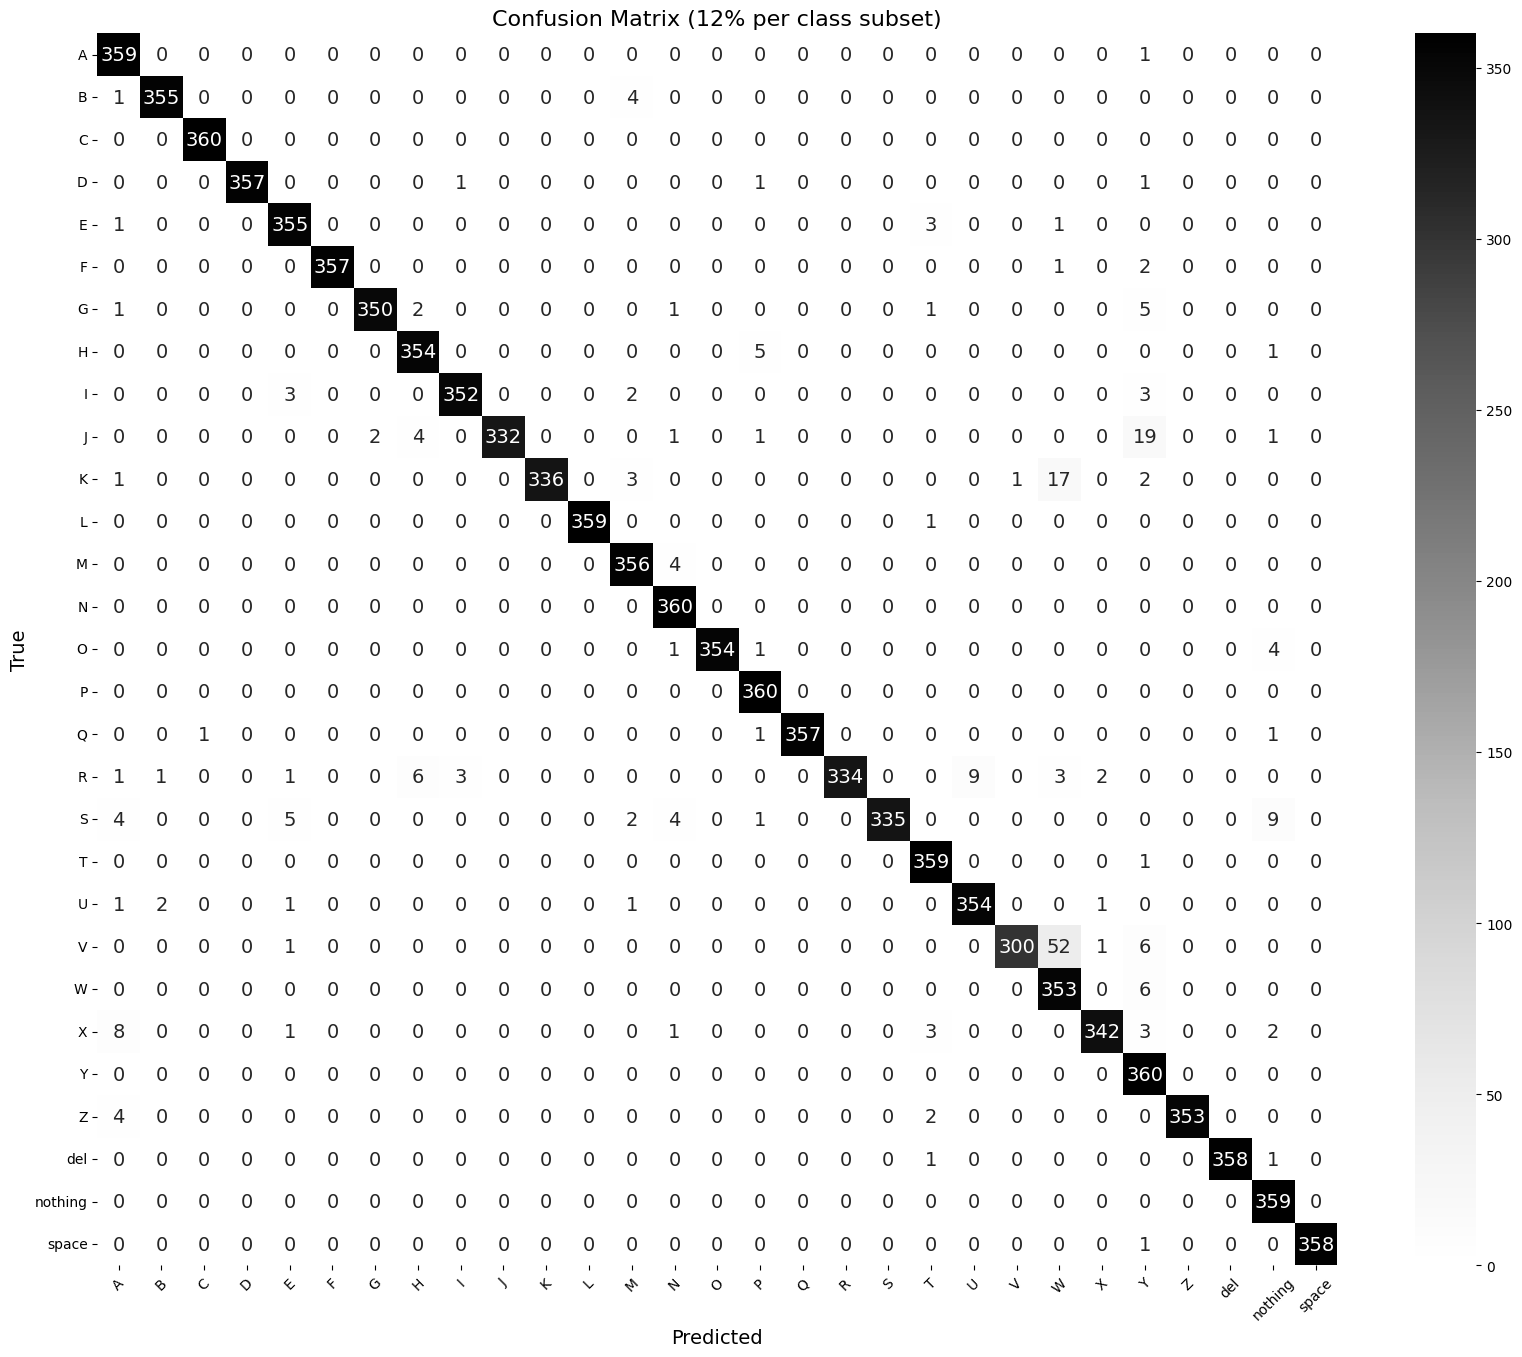

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(20,16))
sns.heatmap(
    cm, 
    annot=True,
    fmt="d",
    cmap="Greys", 
    xticklabels=class_labels, 
    yticklabels=class_labels,
    cbar=True,
    annot_kws={"size":14}
)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.title("Confusion Matrix (12% per class subset)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

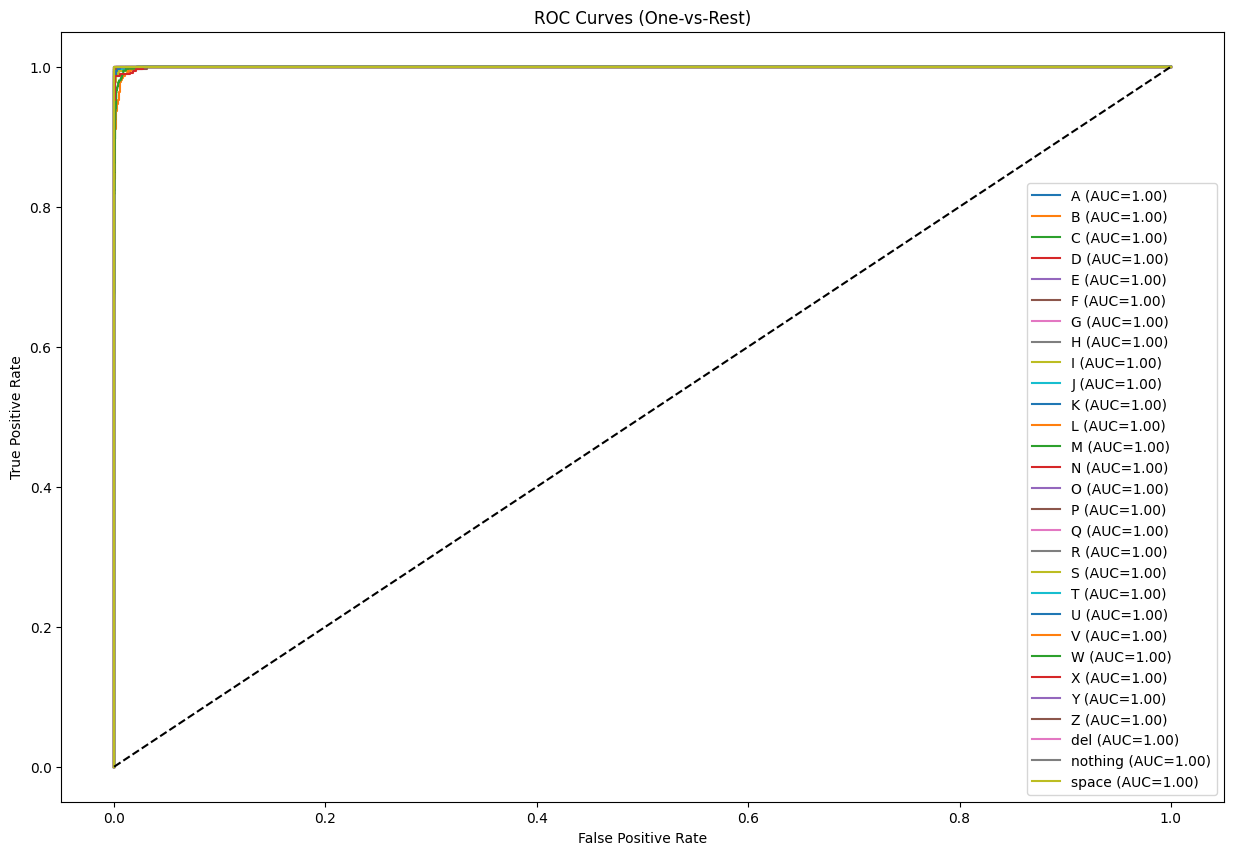

In [12]:
# ROC Curves (one-vs-rest)

y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))
plt.figure(figsize=(15,10))

for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

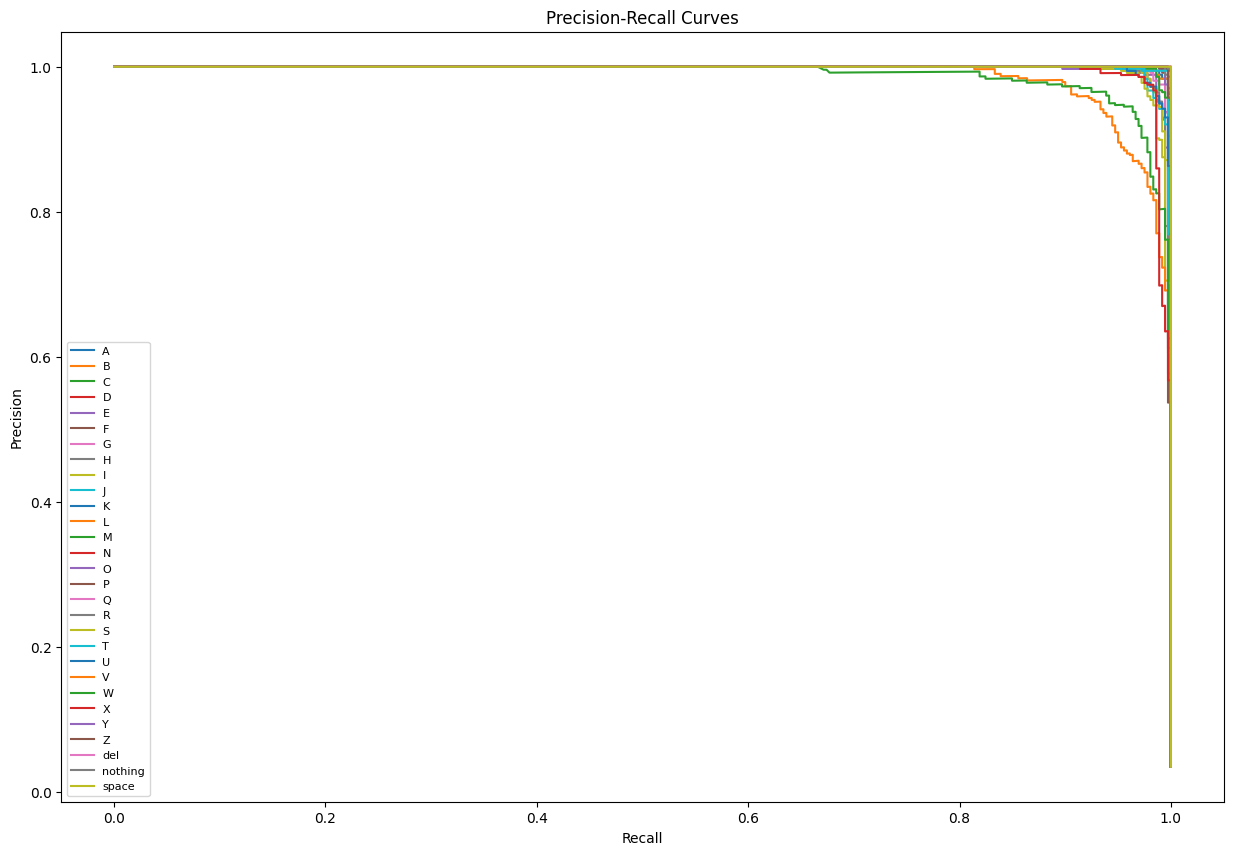

In [13]:
# Precision-Recall Curves (one-vs-rest)
plt.figure(figsize=(15,10))
for i, label in enumerate(class_labels):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=label)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left", fontsize=8)
plt.show()

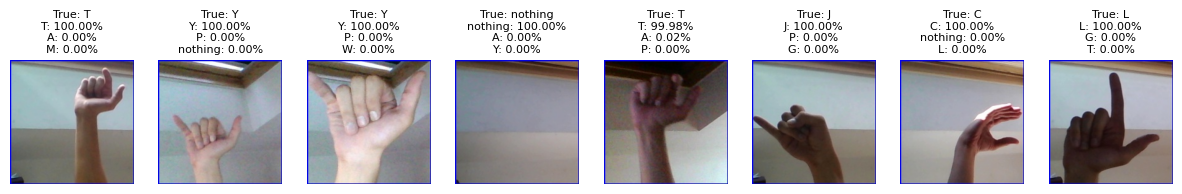

In [14]:
# Sample Predictions
def show_sample_predictions_top3(n=5):
    indices = np.random.choice(len(y_true), n, replace=False)
    plt.figure(figsize=(15,5))
    for i, idx in enumerate(indices):
        img_path = train_gen_eval.filepaths[idx]
        img = plt.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")

        # Top 3 predictions and probabilities
        top_idx = np.argsort(y_pred_prob[idx])[::-1][:3]
        top_preds = [f"{class_labels[j]}: {y_pred_prob[idx][j]*100:.2f}%" for j in top_idx]

        plt.title(f"True: {class_labels[y_true[idx]]}\n" + "\n".join(top_preds), fontsize=8)
    plt.show()

show_sample_predictions_top3(n=8)

Image: ..\data\asl_alphabet_train\Q\Q1804.jpg
True Class: Q
Top 3 Predictions:
Q: 100.00%
T: 0.00%
Y: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\X\X2113.jpg
True Class: X
Top 3 Predictions:
X: 100.00%
A: 0.00%
F: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\S\S182.jpg
True Class: S
Top 3 Predictions:
S: 100.00%
N: 0.00%
nothing: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\F\F13.jpg
True Class: F
Top 3 Predictions:
F: 100.00%
G: 0.00%
Y: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\O\O725.jpg
True Class: O
Top 3 Predictions:
O: 100.00%
N: 0.00%
E: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\D\D1202.jpg
True Class: D
Top 3 Predictions:
D: 100.00%
X: 0.00%
I: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\P\P241.jpg
True Class: P
Top 3 Predictions:
P: 100.00%
N: 0.00%
G: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\G\G557.jpg
True Class: G
To

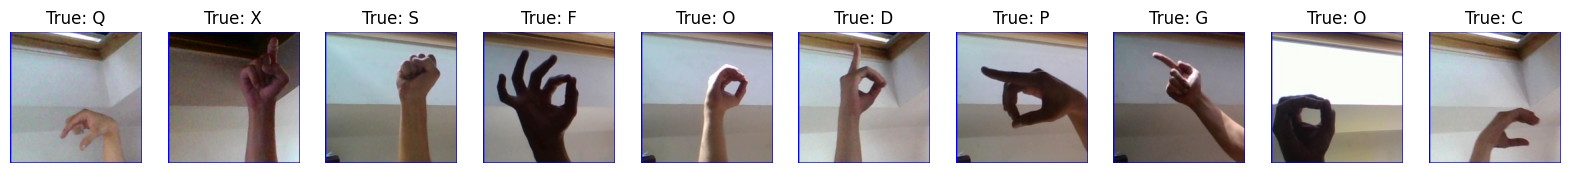

In [15]:
IMG_SIZE = (160, 160)
NUM_IMAGES = 10

# Inverse mapping: index -> class name
idx_to_class = {v: k for k, v in train_gen_eval.class_indices.items()}

plt.figure(figsize=(20, 5))
for i in range(NUM_IMAGES):
    # Random Image from the Dataset
    idx = random.randint(0, len(train_gen_eval.filepaths)-1)
    img_path = train_gen_eval.filepaths[idx]
    true_class_idx = train_gen_eval.classes[idx]
    true_class_name = idx_to_class[true_class_idx]

    # Load & display
    img = plt.imread(img_path)
    plt.subplot(1, NUM_IMAGES, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {true_class_name}")

    # Preprocess & predict
    img_resized = tf.image.resize(img, IMG_SIZE)/255.0
    pred_prob = model.predict(np.expand_dims(img_resized, axis=0), verbose=0)[0]

    # Top 3 predictions
    top_idx = np.argsort(pred_prob)[::-1][:3]
    print(f"Image: {img_path}")
    print(f"True Class: {true_class_name}")
    print("Top 3 Predictions:")
    for idx in top_idx:
        print(f"{idx_to_class[idx]}: {pred_prob[idx]*100:.2f}%")
    print("-------------------------")

plt.show()

Image: ..\data\asl_alphabet_train\V\V1743.jpg
V: 23.26%, W: 76.74%
-------------------------
Image: ..\data\asl_alphabet_train\V\V1779.jpg
V: 100.00%, W: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\V\V2361.jpg
V: 100.00%, W: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\V\V929.jpg
V: 99.96%, W: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\V\V1966.jpg
V: 99.99%, W: 0.01%
-------------------------
Image: ..\data\asl_alphabet_train\V\V1815.jpg
V: 100.00%, W: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\V\V2815.jpg
V: 97.84%, W: 0.02%
-------------------------
Image: ..\data\asl_alphabet_train\V\V958.jpg
V: 100.00%, W: 0.00%
-------------------------
Image: ..\data\asl_alphabet_train\V\V1972.jpg
V: 67.05%, W: 32.87%
-------------------------
Image: ..\data\asl_alphabet_train\V\V1697.jpg
V: 47.69%, W: 52.22%
-------------------------


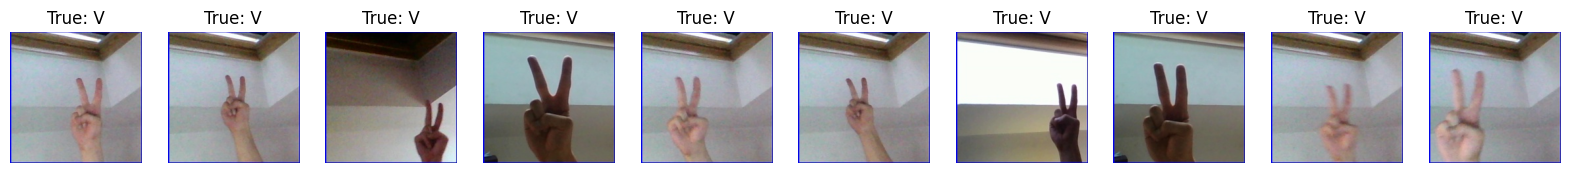

In [16]:
NUM_IMAGES = 10
target_class = "V"

# Get indices of all images belonging to class 'V'
v_indices = [i for i, idx in enumerate(train_gen_eval.classes)
             if idx_to_class[idx] == target_class]

# Randomly pick 10 images
sample_indices = random.sample(v_indices, min(NUM_IMAGES, len(v_indices)))

plt.figure(figsize=(20, 5))
for i, idx in enumerate(sample_indices):
    img_path = train_gen_eval.filepaths[idx]
    true_class_idx = train_gen_eval.classes[idx]
    
    # Load & display image
    img = plt.imread(img_path)
    plt.subplot(1, NUM_IMAGES, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {target_class}")

    # Predict
    img_resized = tf.image.resize(img, IMG_SIZE)/255.0
    pred_prob = model.predict(np.expand_dims(img_resized, axis=0), verbose=0)[0]

    # Show probability for V and W specifically
    prob_v = pred_prob[train_gen_eval.class_indices['V']]*100
    prob_w = pred_prob[train_gen_eval.class_indices['W']]*100
    print(f"Image: {img_path}")
    print(f"V: {prob_v:.2f}%, W: {prob_w:.2f}%")
    print("-------------------------")

plt.show()

Total Misclassified Images: 258


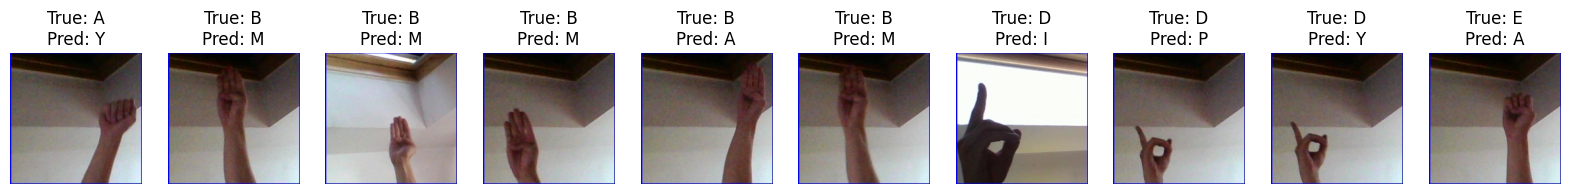

In [17]:
# Misclassified Images
mis_idx = np.where(y_true != y_pred_classes)[0]
print(f"Total Misclassified Images: {len(mis_idx)}")
NUM_MIS = min(10, len(mis_idx))
if NUM_MIS > 0:
    plt.figure(figsize=(20,5))
    for i in range(NUM_MIS):
        idx = mis_idx[i]
        img_path = train_gen_eval.filepaths[idx]
        img = plt.imread(img_path)
        plt.subplot(1, NUM_MIS, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {idx_to_class[y_true[idx]]}\nPred: {idx_to_class[y_pred_classes[idx]]}")
    plt.show()
else:
    print("No misclassified images in this subset.")